<a href="https://colab.research.google.com/github/toliyang/AI_ML/blob/main/calculus/regression_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression in PyTorch

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # E.g.: Dosage of drug for treating Alzheimer's disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error:

In [3]:
# y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)

For reproducibility of this demo, here's a fixed example of $y$ values obtained by running the commented-out line above:

In [4]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

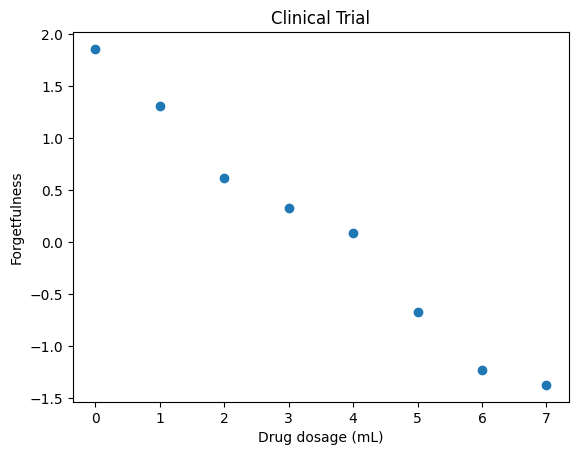

In [5]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

(**N.B.**: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [6]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$:

In [7]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [8]:
def regression(my_x, my_m, my_b):
    return my_m*my_x + my_b

In [10]:
def regression_plot(my_x, my_y, my_m, my_b):

    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)

    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()

    ax.set_xlim([x_min, x_max])
    ax.plot([x_min, x_max], [y_min, y_max])

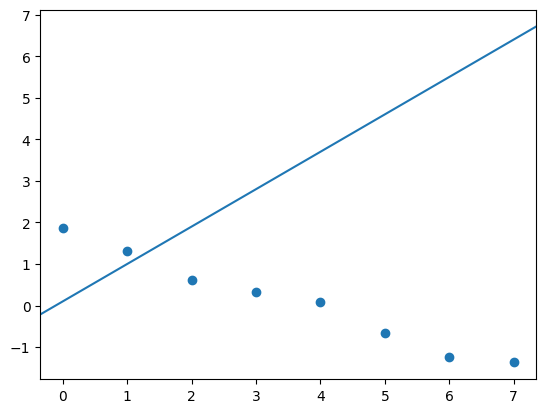

In [11]:
regression_plot(x, y, m, b)

**Return to slides here if following *Calculus I* class.**

### Machine Learning
In four easy steps :)

**Step 1**: Forward pass

In [12]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

There is a PyTorch `cost_funcLoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [40]:
def cost_func(my_yhat, my_y):
    # sigma = torch.sum(abs(my_yhat - my_y))
    sigma = torch.sum(pow((my_yhat - my_y),2))
    return sigma/len(my_y)

In [41]:
C = cost_func(yhat, y)
C

tensor(0.0195, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [15]:
C.backward()

In [16]:
m.grad

tensor([3.2500])

In [17]:
b.grad

tensor([0.5000])

**Step 4**: Gradient descent

In [28]:
optimizer = torch.optim.SGD([m, b], lr=0.02)

In [19]:
optimizer.step()

Confirm parameters have been adjusted sensibly:

In [42]:
print('slope m:',m.item(),'intercept b:',b.item())

slope m: -0.4692866802215576 intercept b: 1.7600047588348389


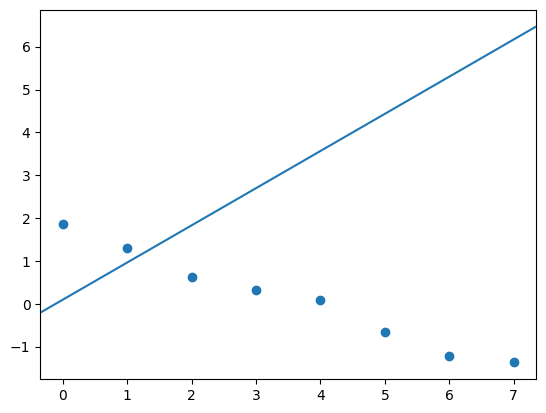

In [22]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has decreased:

In [23]:
C = cost_func(regression(x, m, b), y)
C

tensor(3.5419, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost toward zero:

In [38]:
epochs = 1000
for epoch in range(epochs):

    optimizer.zero_grad() # Reset gradients to zero; else they accumulate

    yhat = regression(x, m, b) # Step 1
    C = cost_func(yhat, y) # Step 2

    C.backward() # Step 3
    optimizer.step() # Step 4

    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 0.0235, m grad 0.483, b grad 0.125
Epoch 1, cost 0.0203, m grad 0.127, b grad 0.0525
Epoch 2, cost 0.0201, m grad 0.0309, b grad 0.0325
Epoch 3, cost 0.02, m grad 0.0047, b grad 0.0269
Epoch 4, cost 0.02, m grad -0.00236, b grad 0.0252
Epoch 5, cost 0.02, m grad -0.00423, b grad 0.0245
Epoch 6, cost 0.02, m grad -0.0047, b grad 0.0241
Epoch 7, cost 0.02, m grad -0.00479, b grad 0.0238
Epoch 8, cost 0.02, m grad -0.00477, b grad 0.0235
Epoch 9, cost 0.02, m grad -0.00472, b grad 0.0233
Epoch 10, cost 0.0199, m grad -0.00467, b grad 0.023
Epoch 11, cost 0.0199, m grad -0.00462, b grad 0.0227
Epoch 12, cost 0.0199, m grad -0.00457, b grad 0.0225
Epoch 13, cost 0.0199, m grad -0.00451, b grad 0.0222
Epoch 14, cost 0.0199, m grad -0.00446, b grad 0.0219
Epoch 15, cost 0.0199, m grad -0.00441, b grad 0.0217
Epoch 16, cost 0.0199, m grad -0.00436, b grad 0.0214
Epoch 17, cost 0.0199, m grad -0.00431, b grad 0.0212
Epoch 18, cost 0.0199, m grad -0.00426, b grad 0.0209
Epoch 19, c

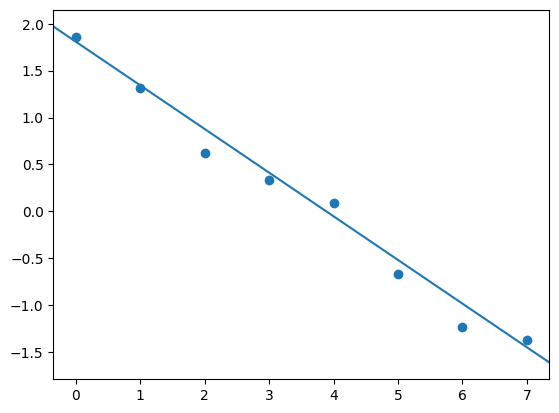

In [30]:
regression_plot(x, y, m, b)

In [39]:
print('slope m:',m.item(),'intercept b:',b.item())

slope: -0.4692866802215576 intercept: 1.7600047588348389


**N.B.**: The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be.